En este primer apartado utilizaremos un dataset de Reddit (incluido en este entregador) para intentar clasificar el subreddit al que pertenece un comentario.

- Tarea 1: Preprocesar el dataset. Realiza los pasos necesarios para normalizar el dataset. Las etiquetas que nos interesan principalmente son las de "comment" y "subreddit".  No obstante, puedes utilizar el resto si deseas profundizar para conseguir un mejor resultado.

- Tarea 2: Utiliza y evalúa modelos para clasificar los textos en función de su subreddit. Para ello, deberás utilizar un conjunto de entrenamiento (80% de los datos) y otro de test (20% de los datos). Evalúa con la métrica "precision" el rendimiento de los modelos que pruebes. Deberás prestar atención a describir los métodos que uses para obtener características del texto y para clasificar. Como mínimo debéis utilizar dos procedimientos distintos, uno de ellos siendo de Machine Learning obligatoriamente.

# Clasificación de textos

## Tarea 1: Preprocesar el dataset

In [1]:
import pandas as pd

Cargamos el CSV original

In [2]:
file_path = "dataset_reddit.csv"
df = pd.read_csv(file_path, sep=",", encoding="utf-8")


Exploramos el dataset

In [3]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      8989 non-null   int64 
 1   label           8989 non-null   int64 
 2   comment         8975 non-null   object
 3   author          8989 non-null   object
 4   subreddit       8989 non-null   object
 5   score           8989 non-null   int64 
 6   ups             8989 non-null   int64 
 7   downs           8989 non-null   int64 
 8   date            8989 non-null   object
 9   created_utc     8989 non-null   object
 10  parent_comment  8989 non-null   object
dtypes: int64(5), object(6)
memory usage: 772.6+ KB
None
   Unnamed: 0  label                                            comment  \
0         235      0  best wall-music experience ever going see roge...   
1         257      0           tend agree you, puppeteers 'persuasive'.   
2         258      0                   

Visualizamos y analizamos los contenidos de las etiquetas "comment" y "subreddit"

In [4]:
df = df[["comment", "subreddit"]]
df_comment = df["comment"]
comments = [line for line in df_comment]
comments

["best wall-music experience ever going see roger water's wall.",
 "tend agree you, puppeteers 'persuasive'.",
 'zionist overlords say is.',
 'seriously, like wwe...',
 'nobody cares.... trump won.. go spam sub bs.',
 'underrated comment',
 'hips lie.',
 'well calexit happens welcomed refugee someone yearns shoot (real) ar-15 freely.',
 'gotta support reasonably priced local brews taste like piss',
 'literally episode south park cartman gets put tunnel?',
 'something afraid might leak marco?',
 'seriously...seems like would done pretty quickly family one victims.',
 'r/thathappened',
 'glenn',
 'hit tv show empire.',
 'fake news joke',
 'people wish rockstar ban multiplayer modding.',
 'yeah, dare stick herself.',
 'cool story bro!',
 "seen gates' name seen something negative started ranting.",
 'maybe whigs.',
 'yea, maga cares!',
 'damn it, make new name.',
 "trump we'd see collapse.",
 'us entire political party keeps saying climate change hoax, fossil fuels fuel future need take co

A simple vista, las siguientes tareas serán:
- Eliminar símbolos relacionados con el salto de línea, tabulaciones y otras similares. (\r)
- Conversión a minúsculas
- Eliminación de puntuaciones
- Eliminación de stopwords
- Eliminación de URLs y etiquetas HTML
- Eliminación de espacios extras/ contracciones

In [5]:
import string
import nltk
from nltk.corpus import stopwords
import contractions
import re
from bs4 import BeautifulSoup
from nltk.stem import SnowballStemmer
import spacy
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\niaib\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\niaib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Limpieza y normalizacion de textos


In [ ]:
# # Conversión a minúsculas
# def conv_minusculas(text):
#     '''
#     Convierte el texto en minúsculas.
#     '''
#     return text.lower()

# # Eliminación de puntuación
# def elim_punct(text):
#     '''
#     Elimina las puntuaciones.
#     '''
#     return text.translate(str.maketrans("","",string.punctuation))

# # Tokenización 
# def word_tok(text):
#     return nltk.word_tokenize(text)

# def sent_tok(text):
#     return nltk.sent_tokenize(text)

# # Eliminar stopwords
# def elim_stopwords(text):
#     return [word for word in text if word.lower() not in stopwords.words("english")]

# # Eliminación de espacios extras
# def elim_extra_space(text):
#     return " ".join(text.split())

# def elim_contract(text):
#     return contractions.fix(text)

# # Eliminación de URLs
# def elim_URL(text):
#     url_pattern = re.compile(r"http[s]?://\S+")
#     return re.sub(url_pattern,"", text)

# # Eliminación de etiquetas HTML
# def elim_HTML(text):
#     return BeautifulSoup(text, "html.parser").get_text()

In [ ]:
def clean_text(texto, stemming=True):
    # Conversión a minúsculas
    texto = texto.lower()

    # Eliminar signos de puntuación
    texto = texto.translate(str.maketrans("","",string.punctuation))

    # Eliminar espacios extra
    texto = " ".join(texto.split())

    # Eliminar contracciones
    texto = contractions.fix(texto)

    # Eliminar URLs
    url_pattern = re.compile(r"http[s]?://\S+")
    texto = re.sub(url_pattern,"", texto)

    # Eliminar etiquetas HTML
    texto = BeautifulSoup(texto, "html.parser").get_text()

    # Tokenización
    tokens = nltk.word_tokenize(texto, "english")

    # Eliminar stopwords
    stopwords_en = set(stopwords.words("english"))
    tokens = [w for w in tokens if w not in stopwords_en]

    # Stemmming
    if stemming:
        stemmer = SnowballStemmer("english")
        tokens = [stemmer.stem(w) for w in tokens]
    # Lematización
    else:
        nlp = spacy.load("en_core_webs")
        doc = nlp(" ".join(tokens))
        tokens = [token.lemma_ for token in doc]
    
    # Reconstruir texto limpio
    texto_limpio = " ".join(tokens)
    return texto_limpio


Aplicar la funciín a la columna comment


In [17]:
df["comment_clean"] = df["comment"].astype(str).apply(clean_text)
df.head(5)

,comment,subreddit,comment_clean
0,best wall-music experience ever going see roge...,Christianity,best wallmus experi ever go see roger water wall
1,"tend agree you, puppeteers 'persuasive'.",conspiracy,tend agre puppet persuas
2,zionist overlords say is.,uncensorednews,zionist overlord say
3,"seriously, like wwe...",worldpolitics,serious like wwe
4,nobody cares.... trump won.. go spam sub bs.,The_Donald,nobodi care trump go spam sub bs


In [23]:
df.isnull().sum()

comment          14
subreddit         0
comment_clean     0
dtype: int64

columna subreddit

Número de clases (subreddits) distintas: 612

Distribución por subreddit:
 subreddit
politics          2423
news               550
worldnews          365
AskReddit          354
TumblrInAction     346
                  ... 
EndlessWar           1
NewOrleans           1
geopolitics          1
ExposurePorn         1
Objectivism          1
Name: count, Length: 612, dtype: int64

Valores nulos en 'subreddit': 0
Valores vacíos o solo espacios en 'subreddit': 0


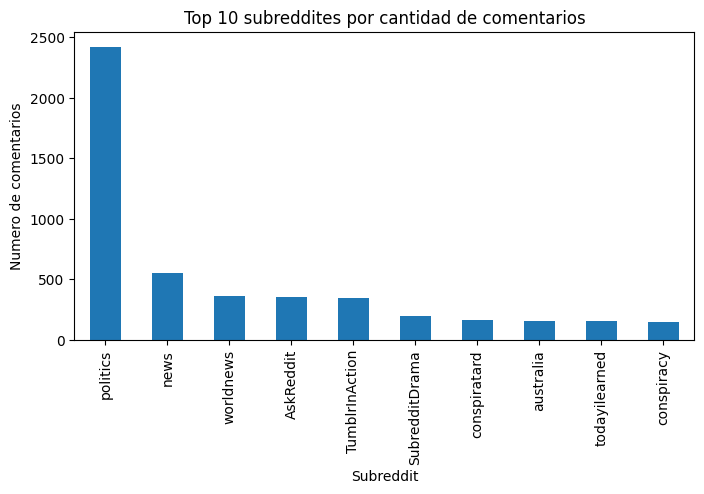

In [32]:
# Valores unicos y cantidad
categorias = df["subreddit"].value_counts()
print("Número de clases (subreddits) distintas:", len(categorias))
print("\nDistribución por subreddit:\n", categorias)

# Revisar valores nulos o vacíos
nulos = df["subreddit"].isnull().sum()
print("\nValores nulos en 'subreddit':", nulos)

vacios = (df["subreddit"].str.strip() == "").sum()
print("Valores vacíos o solo espacios en 'subreddit':", vacios)

# Visualizar graficamente la distribucion
import matplotlib.pyplot as plt

n = 10
categorias.head(n).plot(kind="bar", figsize=(8,4), title= f'Top {n} subreddites por cantidad de comentarios')
plt.xlabel("Subreddit")
plt.ylabel("Numero de comentarios")
plt.show()
